<a href="https://colab.research.google.com/github/ShalilG/Stock-Market-Analysis/blob/main/BacktestMeanReversionUsingOOP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [2]:
pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29104 sha256=2ee80c58b6bf42fc9f216533a8b3123d622ef0f971f2518a4fee58b6d8b1a68e
  Stored in directory: /root/.cache/pip/wheels/31/31/f1/f2ff471bbc5b84a4b973698ceecdd453ae043971791adc3431
Successfully built ta


In [26]:
import yfinance as yf
import pandas as pd
import numpy as np 
import ta
import matplotlib.pyplot as plt

In [73]:
class Backtest:

  def __init__(self, symbol):
    self.symbol = symbol
    self.df = yf.download(self.symbol,start='2019-01-01')
    if self.df.empty:
      print('No data pulled')
    else: 
      self.calc_indicators()
      self.generate_signals()
      self.loop_it()
      self.profit = self.calc_profit()
      self.max_dd = self.profit.min()
      self.cumul_profit = (self.profit + 1).prod() - 1
      
  
  def calc_indicators(self):
    self.df['ma_20'] = self.df.Close.rolling(20).mean()
    self.df['vol'] = self.df.Close.rolling(20).std()
    self.df['upper_bb'] = self.df.ma_20 + (2*self.df.vol)
    self.df['lower_bb'] = self.df.ma_20 - (2*self.df.vol)
    self.df['rsi'] = ta.momentum.rsi(self.df.Close, window=6)
    self.df.dropna(inplace=True)

  def generate_signals(self):
    conditions = [(self.df.rsi < 30) & (self.df.Close < self.df.lower_bb),
                  (self.df.rsi > 70) & (self.df.Close > self.df.upper_bb)]
    choices = ['Buy','Sell']
    self.df['signal'] = np.select(conditions,choices)
    self.df.signal = self.df.signal.shift()
    self.df.dropna(inplace=True)
  
  def loop_it(self):
    position = False
    buydates,selldates = [],[]
  

    for index, row in self.df.iterrows():
      if not position and row['signal'] == 'Buy':
        position = True
        buydates.append(index)
      
      if position and row['signal'] == 'Sell':
        position = False
        selldates.append(index)
    
    self.buy_arr = self.df.loc[buydates].Open
    self.sell_arr = self.df.loc[selldates].Open
  
  def calc_profit(self):
    if self.buy_arr.index[-1] > self.sell_arr.index[-1]:
        self.buy_arr.index[:-1]
    return (self.sell_arr.values- self.buy_arr.values)/self.buy_arr.values
  
  def plot_chart(self):
    plt.figure(figsize=(10,5))
    plt.plot(self.df.Close)
    plt.scatter(self.buy_arr.index, self.buy_arr.values, marker='^', c='g')
    plt.scatter(self.sell_arr.index, self.sell_arr.values, marker='v', c='r')

In [74]:
instance = Backtest('AAPL')

[*********************100%***********************]  1 of 1 completed


In [59]:
instance.profit

array([ 0.14747057,  0.14512763, -0.0616382 ,  0.04193596,  0.0057276 ,
        0.03314114,  0.04132237, -0.00333528])

In [68]:
instance.cumul_profit

0.38541888369034694

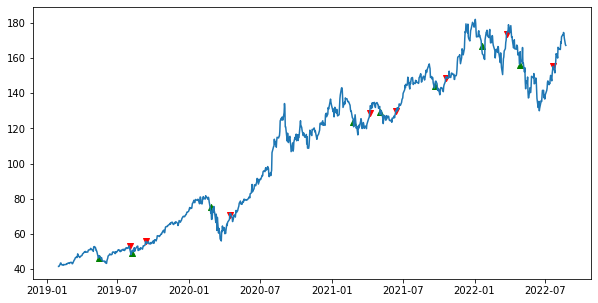

In [76]:
instance.plot_chart()